# import

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc


In [2]:
colors = np.array([[112, 115, 115], [182, 203, 227], [89, 159, 218], 
                   [0, 83, 170], [0, 4, 167], [0, 140, 1]]) / 255.0

# Read variables

In [3]:
# IMERG precipitation
file_path = r"/data92/PeterChang/Paper2/IMERG_from_kai/precipitation_2001_2021_anomaly.nc"
with h5py.File(file_path, "r") as f:
    precip = f["precipitation"][:]  # (time, lat, lon) (7670, 360, 576)

# ERA u wind 
file_path = "/data92/PeterChang/Paper2/Reanalysis/u_kai/ubaro_2001_2022_anomaly.nc"
with nc.Dataset(file_path, "r") as f:
    u_all = f["ubaro"][:] 

# Find u after large-scale precipitation

In [5]:
# select tropical latitude
lat_coarse = np.linspace(-90,90,360)
lat_tropic = (lat_coarse >= -5) & (lat_coarse <= 5)  

# select the precipitation in tropics and weighted-average
precip_tropic = precip[:, lat_tropic, :] * np.cos(np.deg2rad(lat_coarse[lat_tropic]))[np.newaxis, :,np.newaxis] **0.5   

# Calculate tropicaly zonal mean
precip_tropic_zonal_mean = np.average(precip_tropic, axis=(1,2)) # (time,)

In [6]:
# Calculate the extreme precipitation (mean +- 1σ)
mean_precip = np.nanmean(precip_tropic_zonal_mean)
std_precip  = np.nanstd(precip_tropic_zonal_mean)   
extreme_threshold     = mean_precip + 1 * std_precip    
extreme_threshold_dry = mean_precip - 1 * std_precip    

# 選select the event out of the threshold
extreme_precip = precip_tropic_zonal_mean[precip_tropic_zonal_mean > extreme_threshold]
extreme_dry    = precip_tropic_zonal_mean[precip_tropic_zonal_mean < extreme_threshold_dry]

print("The number of extreme precip:", extreme_precip.shape[0])
print("The number of extreme dry:"   , extreme_dry.shape[0])


The number of extreme precip: 1174
The number of extreme dry: 1174


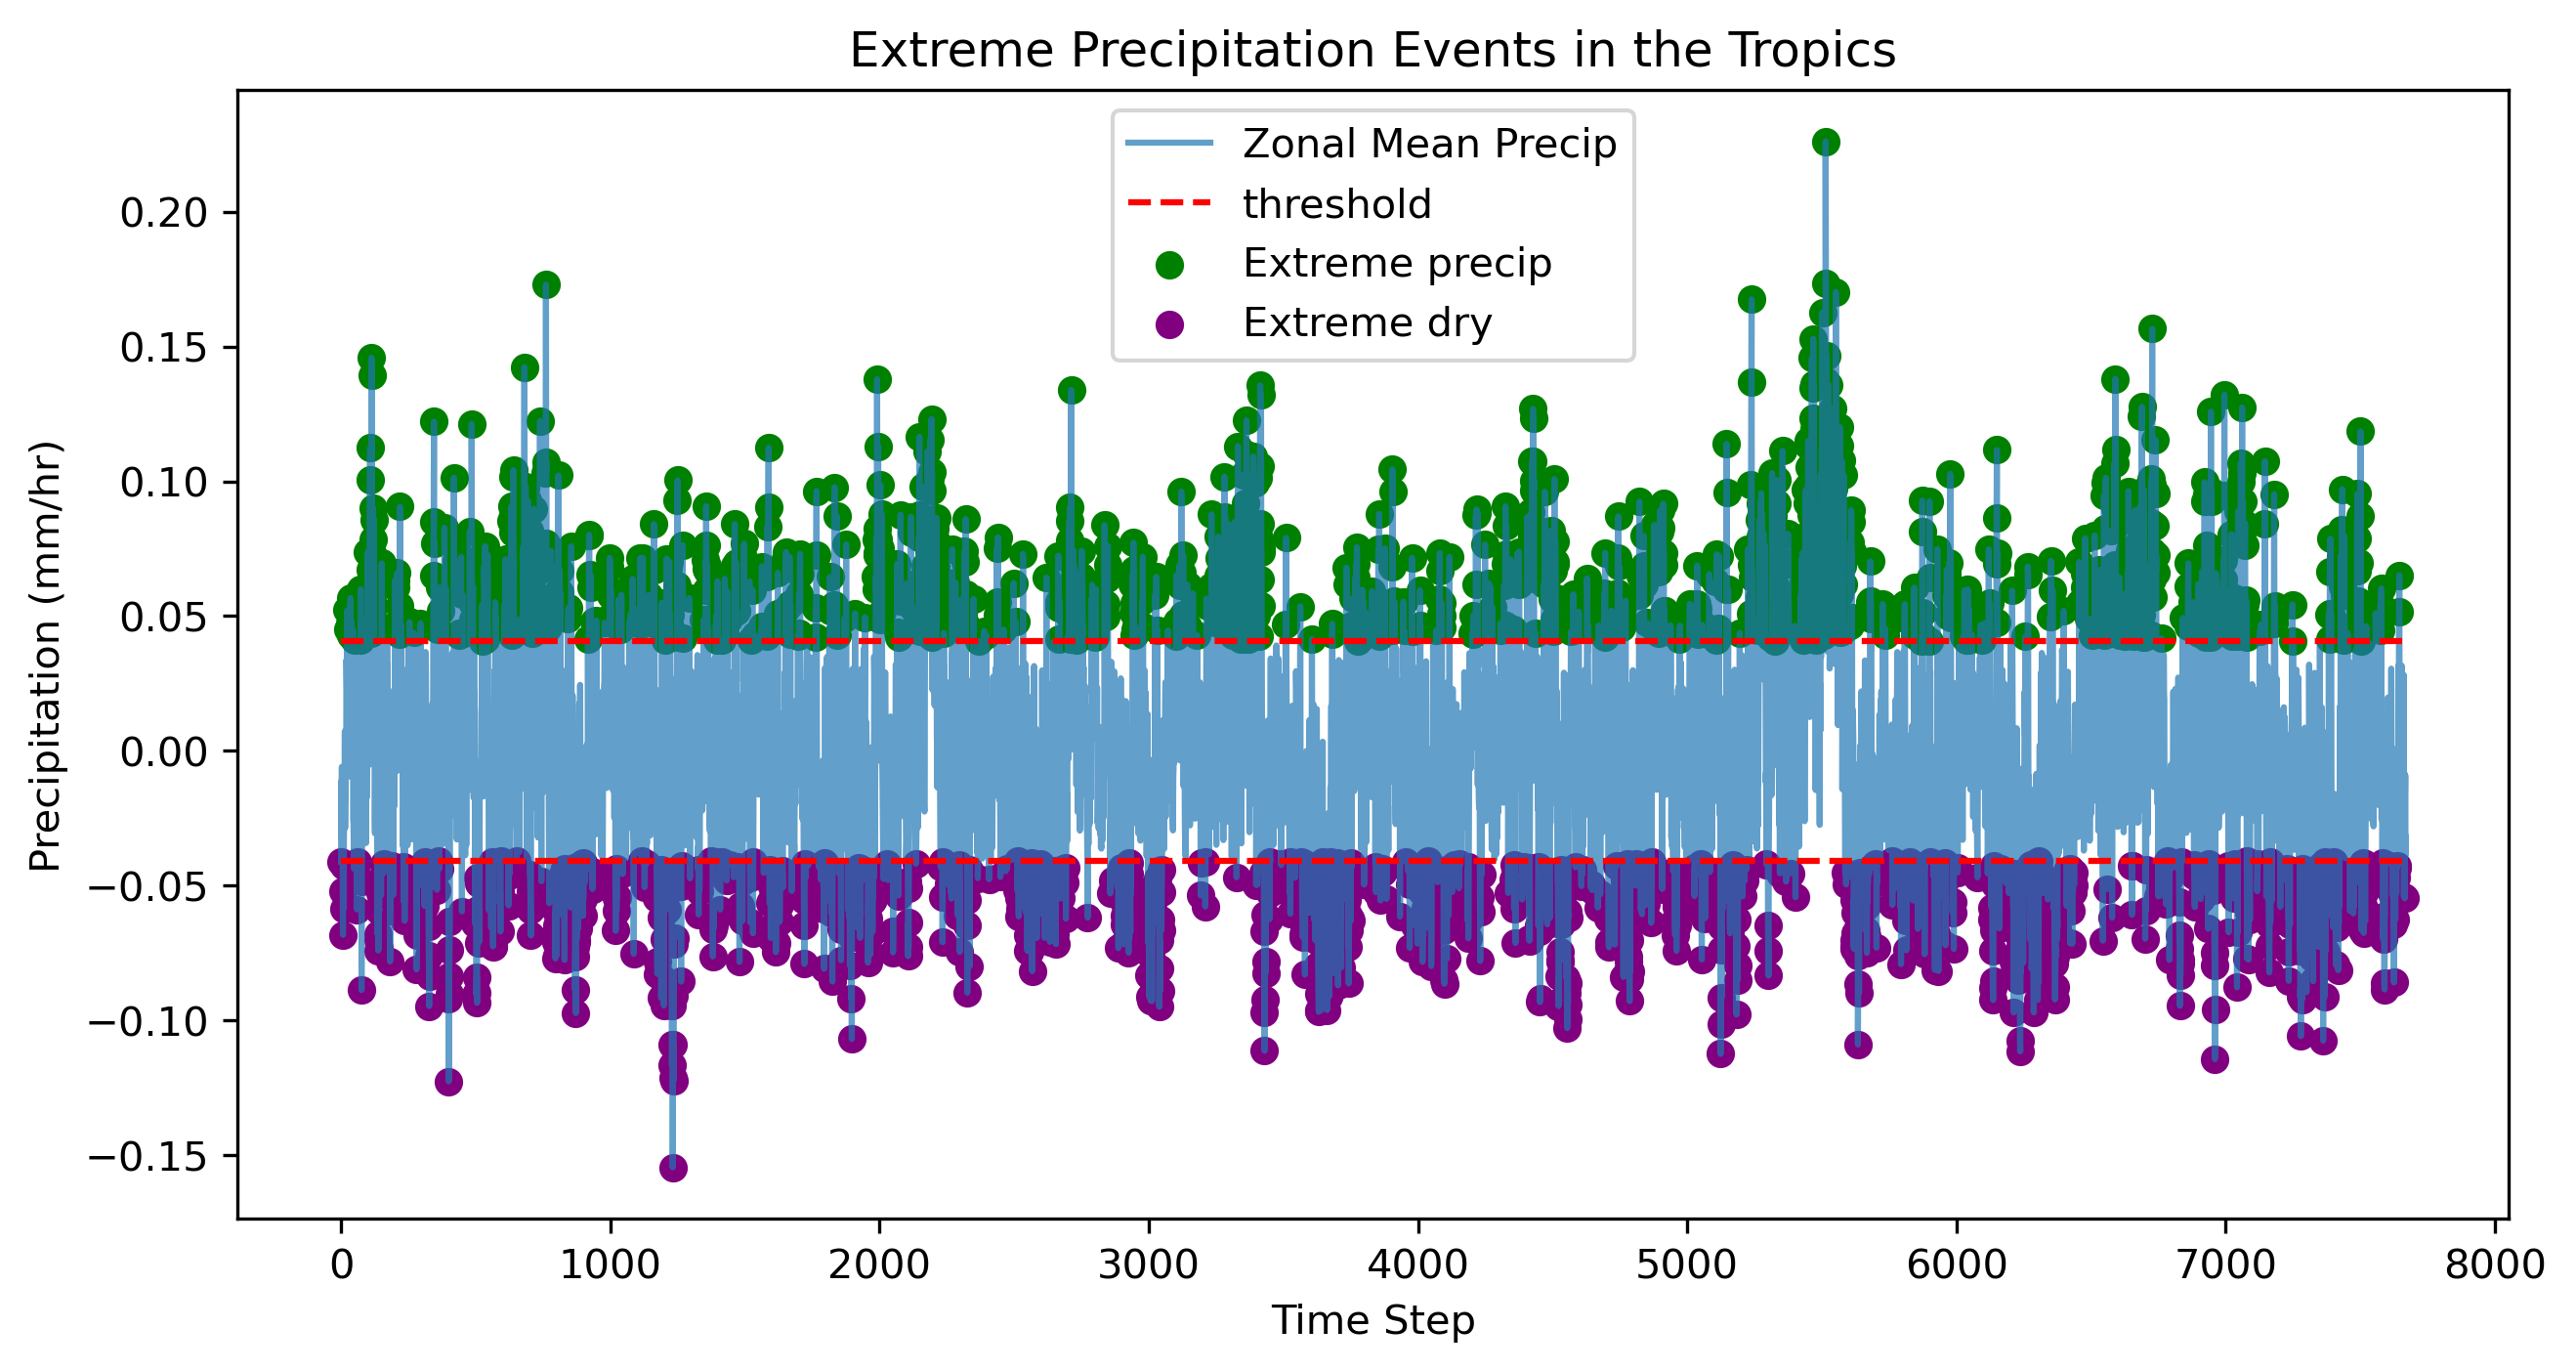

In [7]:
# find the boolean
extreme_indices     = np.where(precip_tropic_zonal_mean > extreme_threshold)[0]
extreme_indices_dry = np.where(precip_tropic_zonal_mean < extreme_threshold_dry)[0]


plt.figure(figsize=(10, 5), dpi=300.)
plt.plot(precip_tropic_zonal_mean, label="Zonal Mean Precip", alpha=0.7)  # (time,)

plt.hlines(y=extreme_threshold, xmin=0, xmax=len(precip_tropic_zonal_mean)-1, color="red", linestyle="dashed", label="threshold")  
plt.hlines(y=extreme_threshold_dry, xmin=0, xmax=len(precip_tropic_zonal_mean)-1, color="red", linestyle="dashed")

plt.scatter(extreme_indices, extreme_precip, color="Green", label="Extreme precip")
plt.scatter(extreme_indices_dry, extreme_dry, color="Purple", label="Extreme dry")  

plt.xlabel("Time Step")
plt.ylabel("Precipitation (mm/hr)")
plt.legend()
plt.title("Extreme Precipitation Events in the Tropics")
plt.show()


In [20]:
lag = 20
extreme_indices_lag     = extreme_indices     + lag
extreme_indices_dry_lag = extreme_indices_dry + lag


extreme_indices_lag     = extreme_indices_lag[extreme_indices_lag < int(u_all.shape[0]-lag)]
extreme_indices_dry_lag = extreme_indices_dry_lag[extreme_indices_dry_lag<int(u_all.shape[0]-lag)]

print(u_all[extreme_indices_lag].shape)
print(u_all[extreme_indices_dry_lag].shape)


(1172, 360, 576)
(1167, 360, 576)


In [21]:
final_u     = u_all[extreme_indices_lag].mean(axis=(0,2))
final_u_dry = u_all[extreme_indices_dry_lag].mean(axis=(0,2))
u_diff = final_u - final_u_dry

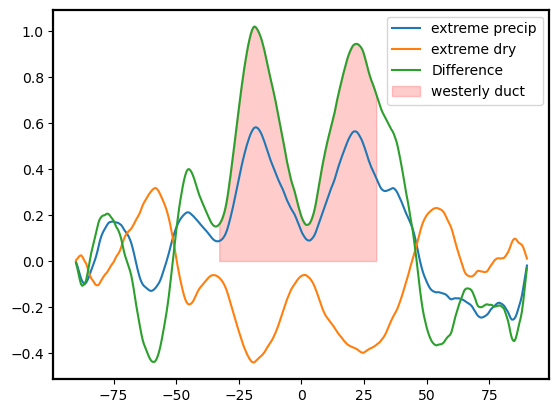

In [22]:
plt.figure()
plt.plot(lat_coarse, final_u, label="extreme precip")
plt.plot(lat_coarse, final_u_dry, label="extreme dry")
plt.plot(lat_coarse, u_diff, label="Difference")
plt.fill_between(
    lat_coarse, u_diff, 0, 
    where=(lat_coarse >= -33) & (lat_coarse <= 30), 
    color='red', alpha=0.2, label="westerly duct"
)

plt.legend()

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 設定 lag 範圍
lag_range = np.arange(10, 21)  # 5~20 天

# 初始化累積變數
final_u_sum = np.zeros((u_all.shape[1],))  # (lat,)
final_u_dry_sum = np.zeros((u_all.shape[1],))

# 計算不同 lag 的 composite
for lag in lag_range:
    extreme_indices_lag = extreme_indices + lag
    extreme_indices_dry_lag = extreme_indices_dry + lag

    # 避免超過數據範圍
    extreme_indices_lag = extreme_indices_lag[extreme_indices_lag < int(u_all.shape[0] - lag)]
    extreme_indices_dry_lag = extreme_indices_dry_lag[extreme_indices_dry_lag < int(u_all.shape[0] - lag)]

    # 計算 composite
    final_u_lag = u_all[extreme_indices_lag].mean(axis=(0, 2))  # (lat,)
    final_u_dry_lag = u_all[extreme_indices_dry_lag].mean(axis=(0, 2))

    # 累積結果
    final_u_sum += final_u_lag
    final_u_dry_sum += final_u_dry_lag

# 計算平均
final_u_avg = final_u_sum / len(lag_range)
final_u_dry_avg = final_u_dry_sum / len(lag_range)




In [30]:
u_diff_avg = final_u_avg - final_u_dry_avg

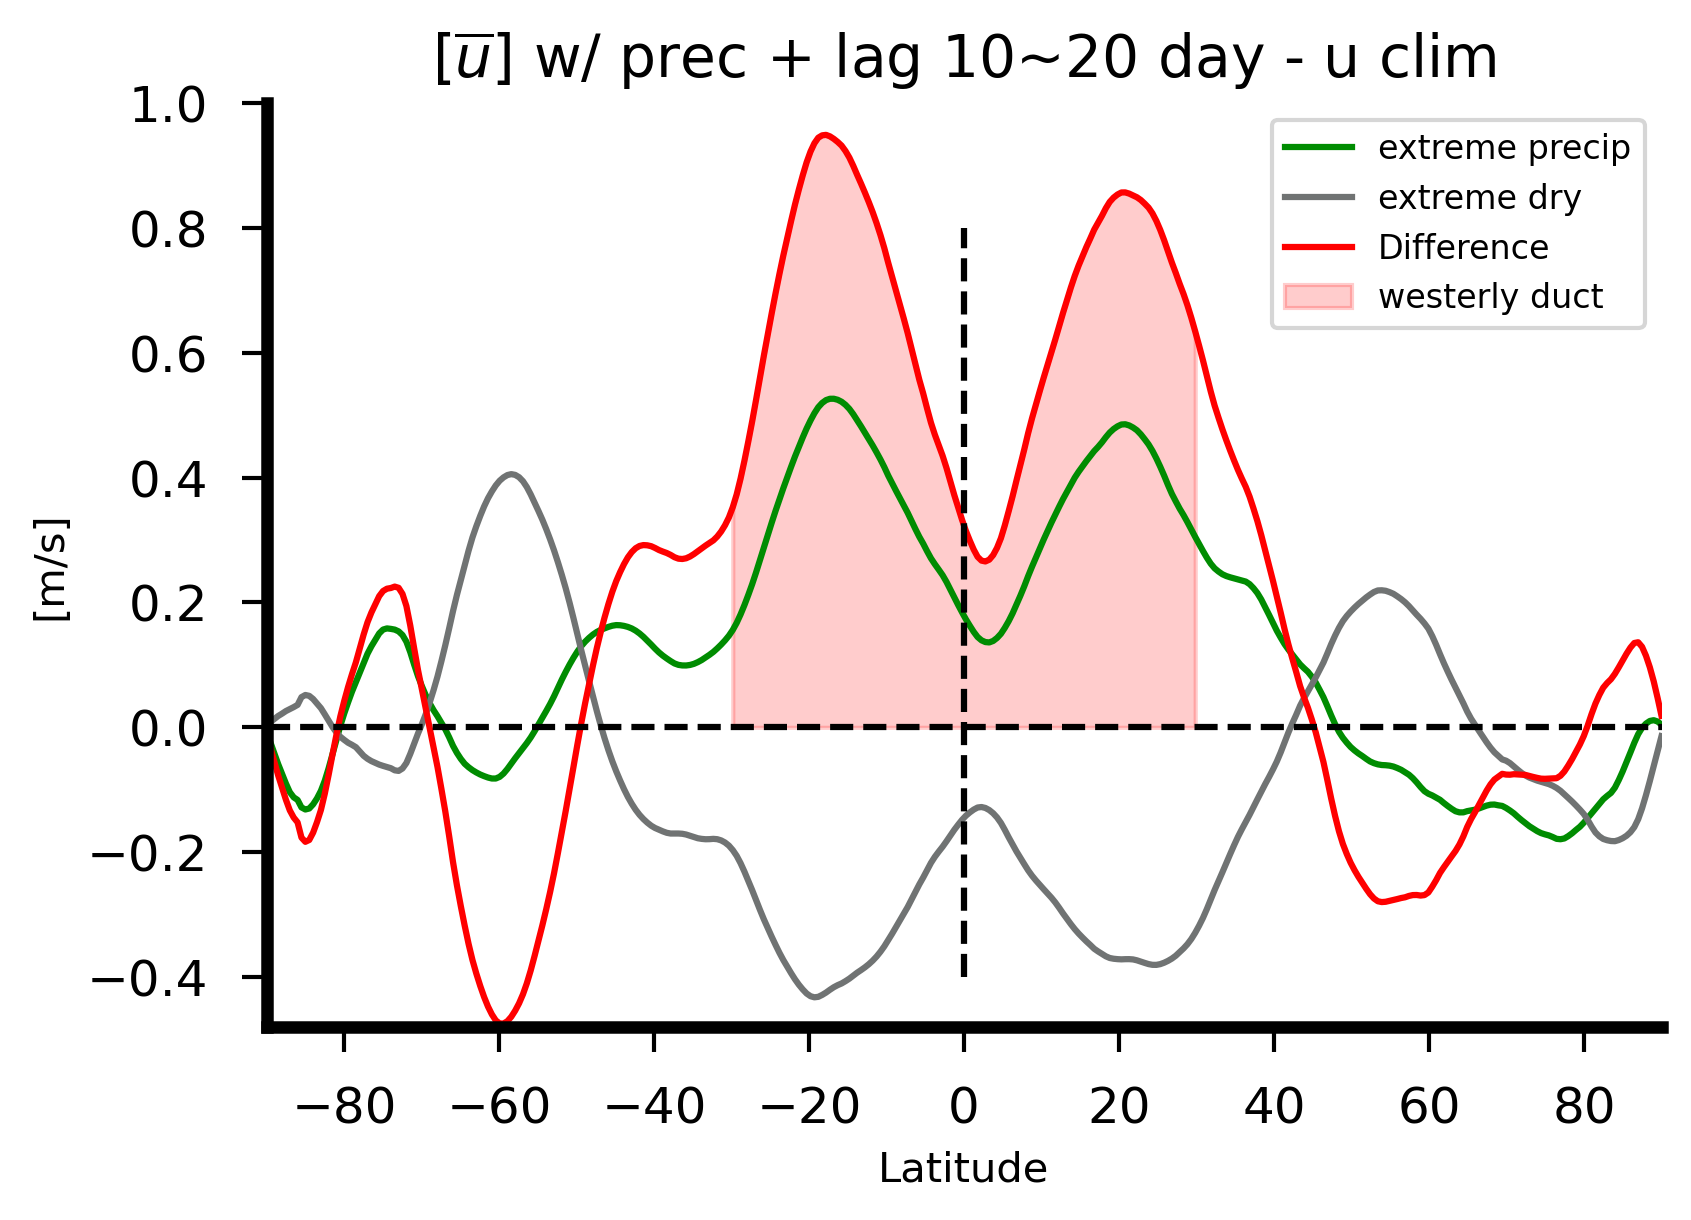

In [45]:
# 繪圖
fig, ax = plt.subplots(1, figsize=(6,4), dpi=300.)
mpl.rcParams['axes.linewidth'] = 1.6

ax.plot(lat_coarse, final_u_avg, label="extreme precip", color=colors[-1])
ax.plot(lat_coarse, final_u_dry_avg, label="extreme dry", color=colors[0])
ax.plot(lat_coarse, u_diff_avg, label="Difference", color="Red")

ax.fill_between(
    lat_coarse, u_diff_avg, 0, 
    where=(lat_coarse >= -30) & (lat_coarse <= 30), 
    color='red', alpha=0.2, label="westerly duct"
)

ax.set_xlabel("Latitude")
ax.set_ylabel("[m/s]")
ax.set_title(r"[$\overline{u}$]" +f" w/ prec + lag 10~20 day - u clim", fontsize=14)

ax.legend(fontsize=8)
# ax.grid()
ax.hlines(y=0, xmin=-90,xmax=90, lw=1.5,linestyles='--', color="Black")
ax.vlines(x=0, ymin=-0.4,ymax=0.8, lw=1.5,linestyles='--', color="Black")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim([-0.48, 1])
ax.tick_params(axis="x", labelsize=12, pad=8)
ax.tick_params(axis="y", labelsize=12, pad=8)
ax.tick_params(direction="out", length=6, width=1)
ax.set_xlim([-90,90])
plt.savefig(r"/data92/PeterChang/Paper2/Figure/Reanalysis_westly_duct2.png", dpi=300.)
plt.show()

#  Autocorrelation

In [36]:
# zonal mean
barotropic_u_zonal_mean = u_all.mean(axis=2) # (time, lat)
print(barotropic_u_zonal_mean.shape)

(7670, 360)


In [37]:
def Cal_EOF_PC_for_barotropic(input_data):
    from EOF import EOF
    # input : (time, y)
    
    # Perform latitude weighting
    input_data_weighted = input_data * np.sqrt(np.cos(np.deg2rad(np.linspace(-90, 0, input_data.shape[1]))))

    # Initialize an EOF instance with weighted input data
    n_component = min(input_data.shape[0], input_data.size // input_data.shape[0])

    print("n_component:", n_component)
    eof_instance = EOF((input_data_weighted,), n_components=n_component, field="1D")
    
    # Compute EOFs and PCs
    eof_instance.get()
    
    # Retrieve EOFs and PCs and Extract EOF1, PC1, EOF2, and PC2
    EOF1, EOF2 = eof_instance.EOF[:2]
    PC1, PC2 = eof_instance.PC[:2]

    # Normalize PCs and EOFs
    PC1_norm, PC2_norm = PC1 / PC1.std(), PC2 / PC2.std()
    EOF1_norm, EOF2_norm = EOF1 * PC1.std(), EOF2 * PC2.std()
    
    return EOF1_norm, PC1_norm, EOF2_norm, PC2_norm

In [38]:
EOF1, PC1, EOF2, PC2 = Cal_EOF_PC_for_barotropic(barotropic_u_zonal_mean[:,:180])

n_component: 180


## Checking EOF1,2 and PC1,2 correction

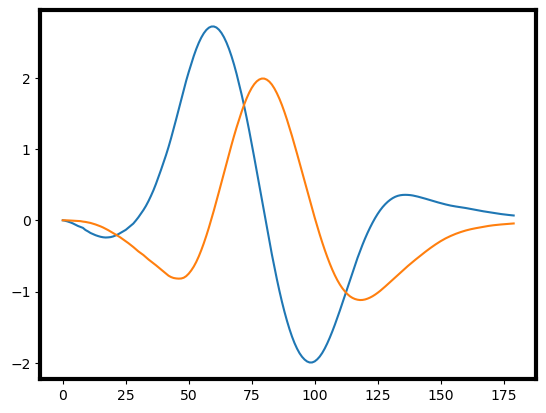

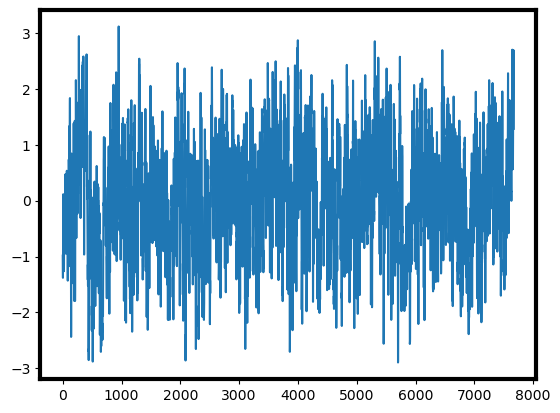

In [39]:
plt.figure()
plt.plot(EOF1)
plt.plot(-EOF2)
plt.figure()
plt.plot(PC1)


In [40]:
def autocorr(x, lags, split_to_chunk=False, window_length=None, overlap_ratio=0.5, avg_chunks=True):
    """
    Computes the Auto-correlation Function (ACF).
    
    Parameters:
    - x : array-like
        Input data.
    - lags : int
        Number of time lags to compute.
    - split_to_chunk : bool, default False
        Whether to split the data into sub-windows for computation.
    - window_length : int, default None
        If split_to_chunk=True, this specifies the length of each window.
    - overlap_ratio : float, default 0.5
        The overlap ratio between windows (0.0 means no overlap, 0.5 means 50% overlap).
    - avg_chunks : bool, default True
        If split_to_chunk=True, whether to average the results across different windows.

    Returns:
    - autocorrs : np.array
        Computed auto-correlation function values, shape (lags,) or (window_number, lags).
    """
    
    x = np.asarray(x)  # Ensure x is a NumPy array
    N = len(x)

    if not split_to_chunk:
        # Directly compute global auto-correlation
        autocorrs = np.array([1.0 if l == 0 else np.corrcoef(x[:-l], x[l:])[0, 1] for l in range(lags)])
        return autocorrs

    else:
        if window_length is None or window_length > N:
            raise ValueError("Please provide a valid window_length and ensure it is less than the data length.")
        
        step_size = int(window_length * (1 - overlap_ratio))  # Compute sliding step size
        if step_size == 0:
            raise ValueError("overlap_ratio is too large, resulting in a step size of 0. Choose a smaller overlap_ratio.")

        # Compute window start indices
        window_starts = np.arange(0, N - window_length + 1, step_size)
        window_number = len(window_starts)

        autocorrs = np.zeros((window_number, lags))  # Store results for each window

        for i, start in enumerate(window_starts):
            x_window = x[start:start + window_length]
            autocorrs[i] = np.array([1.0 if l == 0 else np.corrcoef(x_window[:-l], x_window[l:])[0, 1] 
                                     for l in range(lags)])

        if avg_chunks:
            return autocorrs.mean(axis=0)  # Return the averaged auto-correlation
        else:
            return autocorrs  # Return auto-correlation for all windows

# Test the new autocorrelation function (including overlap)
auto_length = 20
window_length = 20
split_to_chunk = False
overlap_ratio = 0.5  # 50% overlap

auto_all = autocorr(PC1[:], auto_length, split_to_chunk, window_length, overlap_ratio) 
auto_precip = autocorr(PC1[extreme_indices_lag], auto_length, split_to_chunk, window_length, overlap_ratio) 
auto_dry = autocorr(PC1[extreme_indices_dry_lag], auto_length, split_to_chunk, window_length, overlap_ratio) 


In [41]:
autocorre = np.zeros(20)
extreme_indices_lag = np.zeros(extreme_indices.shape)
aa = 0
for i in range(20):
    extreme_indices_lag = extreme_indices + i
    extreme_indices_lag = extreme_indices_lag[extreme_indices_lag < PC1.shape[0]]

    # Ensure both arrays have the same shape
    min_length = min(len(extreme_indices), len(extreme_indices_lag))
    autocorre[aa] = np.corrcoef(PC1[extreme_indices[:min_length]], PC1[extreme_indices_lag[:min_length]])[0, 1]
    aa += 1
print(autocorre)

######################################################################################################
# dry
autocorre_dry = np.zeros(20)
extreme_indices_lag_dry = np.zeros(extreme_indices_dry.shape)

aa = 0
for i in range(20):
    extreme_indices_lag_dry = extreme_indices_dry + i
    extreme_indices_lag_dry = extreme_indices_lag_dry[extreme_indices_lag_dry < PC1.shape[0]]

    # Ensure both arrays have the same shape
    min_length = min(len(extreme_indices_dry), len(extreme_indices_lag_dry))
    autocorre_dry[aa] = np.corrcoef(PC1[extreme_indices_dry[:min_length]], PC1[extreme_indices_lag_dry[:min_length]])[0, 1]
    aa += 1
print(autocorre_dry)


[1.         0.93501941 0.80158779 0.6798406  0.5881415  0.51789711
 0.45345883 0.40466069 0.37130522 0.34366367 0.3293426  0.30484943
 0.26582462 0.22900154 0.21164469 0.2104996  0.21037532 0.1935677
 0.1683632  0.14543793]
[1.         0.93737728 0.81115398 0.68979433 0.60274195 0.54247311
 0.49217493 0.44847093 0.41375247 0.38926579 0.36345422 0.34030459
 0.31691115 0.29366759 0.28149687 0.26646238 0.24263588 0.21957673
 0.19535747 0.15758155]


In [42]:
# 初始化對稱陣列
autocorre_symmetric = np.zeros(40)
autocorre_dry_symmetric = np.zeros(40)
auto_all_symmetric = np.zeros(40)

# 合併處理三個對稱陣列
for l in range(-20, 21):  # 包含 -20 到 20
    if l == 20:
        autocorre_symmetric[l] = 1.0
        autocorre_dry_symmetric[l] = 1.0
        auto_all_symmetric[l] = 1.0
    elif l > 0:
        autocorre_symmetric[l] = autocorre[-l]
        autocorre_dry_symmetric[l] = autocorre_dry[-l]
        auto_all_symmetric[l] = auto_all[-l]
    else:
        autocorre_symmetric[l] = autocorre[l]
        autocorre_dry_symmetric[l] = autocorre_dry[l]
        auto_all_symmetric[l] = auto_all[l]

# 單獨處理 l == -20 對應索引 0
autocorre_symmetric[0] = autocorre[-1]
autocorre_dry_symmetric[0] = autocorre_dry[-1]
auto_all_symmetric[0] = auto_all[-1]

print("autocorre_symmetric:", autocorre_symmetric)
print("autocorre_dry_symmetric:", autocorre_dry_symmetric)
print("auto_all_symmetric:", auto_all_symmetric)


autocorre_symmetric: [0.14543793 0.14543793 0.1683632  0.1935677  0.21037532 0.2104996
 0.21164469 0.22900154 0.26582462 0.30484943 0.3293426  0.34366367
 0.37130522 0.40466069 0.45345883 0.51789711 0.5881415  0.6798406
 0.80158779 0.93501941 1.         0.93501941 0.80158779 0.6798406
 0.5881415  0.51789711 0.45345883 0.40466069 0.37130522 0.34366367
 0.3293426  0.30484943 0.26582462 0.22900154 0.21164469 0.2104996
 0.21037532 0.1935677  0.1683632  0.14543793]
autocorre_dry_symmetric: [0.15758155 0.15758155 0.19535747 0.21957673 0.24263588 0.26646238
 0.28149687 0.29366759 0.31691115 0.34030459 0.36345422 0.38926579
 0.41375247 0.44847093 0.49217493 0.54247311 0.60274195 0.68979433
 0.81115398 0.93737728 1.         0.93737728 0.81115398 0.68979433
 0.60274195 0.54247311 0.49217493 0.44847093 0.41375247 0.38926579
 0.36345422 0.34030459 0.31691115 0.29366759 0.28149687 0.26646238
 0.24263588 0.21957673 0.19535747 0.15758155]
auto_all_symmetric: [0.16118833 0.16118833 0.18322479 0.201815

In [43]:
autocorre_symmetric

array([0.14543793, 0.14543793, 0.1683632 , 0.1935677 , 0.21037532,
       0.2104996 , 0.21164469, 0.22900154, 0.26582462, 0.30484943,
       0.3293426 , 0.34366367, 0.37130522, 0.40466069, 0.45345883,
       0.51789711, 0.5881415 , 0.6798406 , 0.80158779, 0.93501941,
       1.        , 0.93501941, 0.80158779, 0.6798406 , 0.5881415 ,
       0.51789711, 0.45345883, 0.40466069, 0.37130522, 0.34366367,
       0.3293426 , 0.30484943, 0.26582462, 0.22900154, 0.21164469,
       0.2104996 , 0.21037532, 0.1935677 , 0.1683632 , 0.14543793])

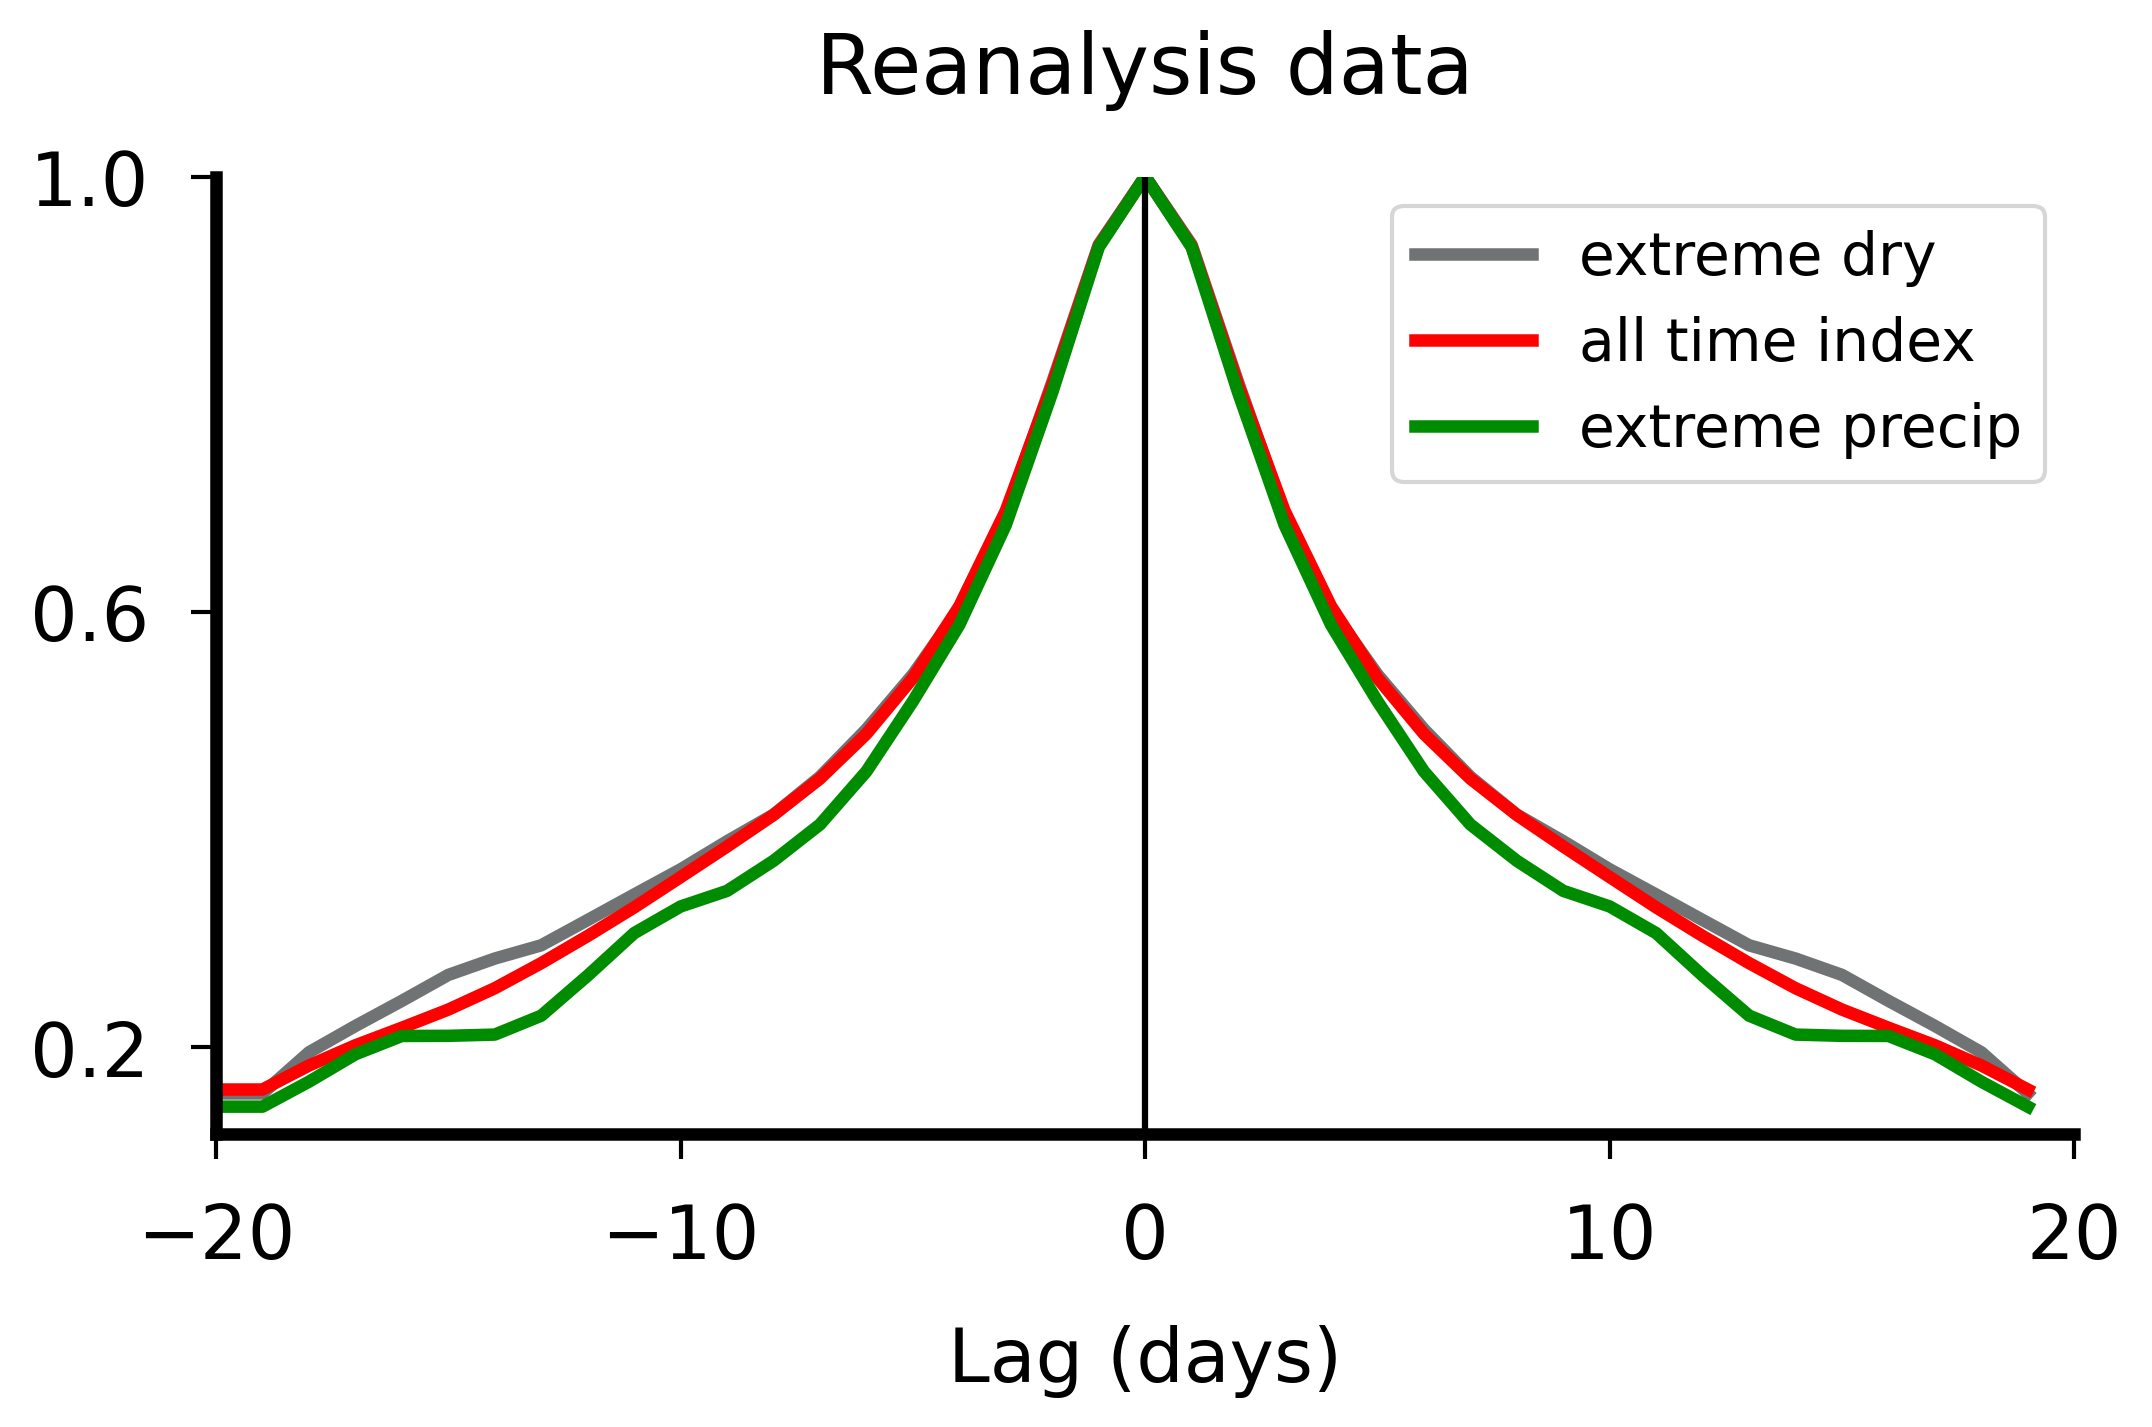

In [44]:
# Plot the symmetric autocorrelation
import matplotlib as mpl
lags = np.arange(-20, 20, 1)

fig, ax = plt.subplots(1, figsize=(8, 5), dpi=300)
mpl.rcParams['axes.linewidth'] = 3

ax.plot(lags, autocorre_dry_symmetric, color=colors[0], lw=3, label="extreme dry")
ax.plot(lags, auto_all_symmetric, color="Red", lw=3, label="all time index")
ax.plot(lags, autocorre_symmetric, color=colors[-1], lw=3, label="extreme precip")


ax.set_title("Reanalysis data", fontsize=20, pad=20)
ax.set_xlabel("Lag (days)", fontsize=14)
# ax.set_ylabel("Autocorrelation", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='x', labelsize=50)
ax.tick_params(axis='y', labelsize=50)
plt.legend(fontsize=14)
# plt.grid()
plt.tight_layout()
# plt.vlines(x=0, ymin=0.12, ymax=1, color='Black')
plt.ylim([0.12,1])
plt.xlim([-20,20])


ax.set_xlabel("Lag (days)", fontsize=18, labelpad=12)
ax.tick_params(axis='x', labelsize=18, pad=10)
ax.tick_params(axis='y', labelsize=18, pad=10)
ax.tick_params(direction='out', length=6, width=1)
ax.set_xticks(np.linspace(-20,20,5))
ax.set_yticks(np.linspace(0.2,1,3))

ax.vlines(x=0, ymin=-0.1, ymax=1.05, color="black", lw=1.5)

plt.savefig(r"/data92/PeterChang/Paper2/Figure/Reanalysis_autocorrelation.png", dpi=300., bbox_inches='tight')


## Conbine Fig.7a and b for Dean's Award

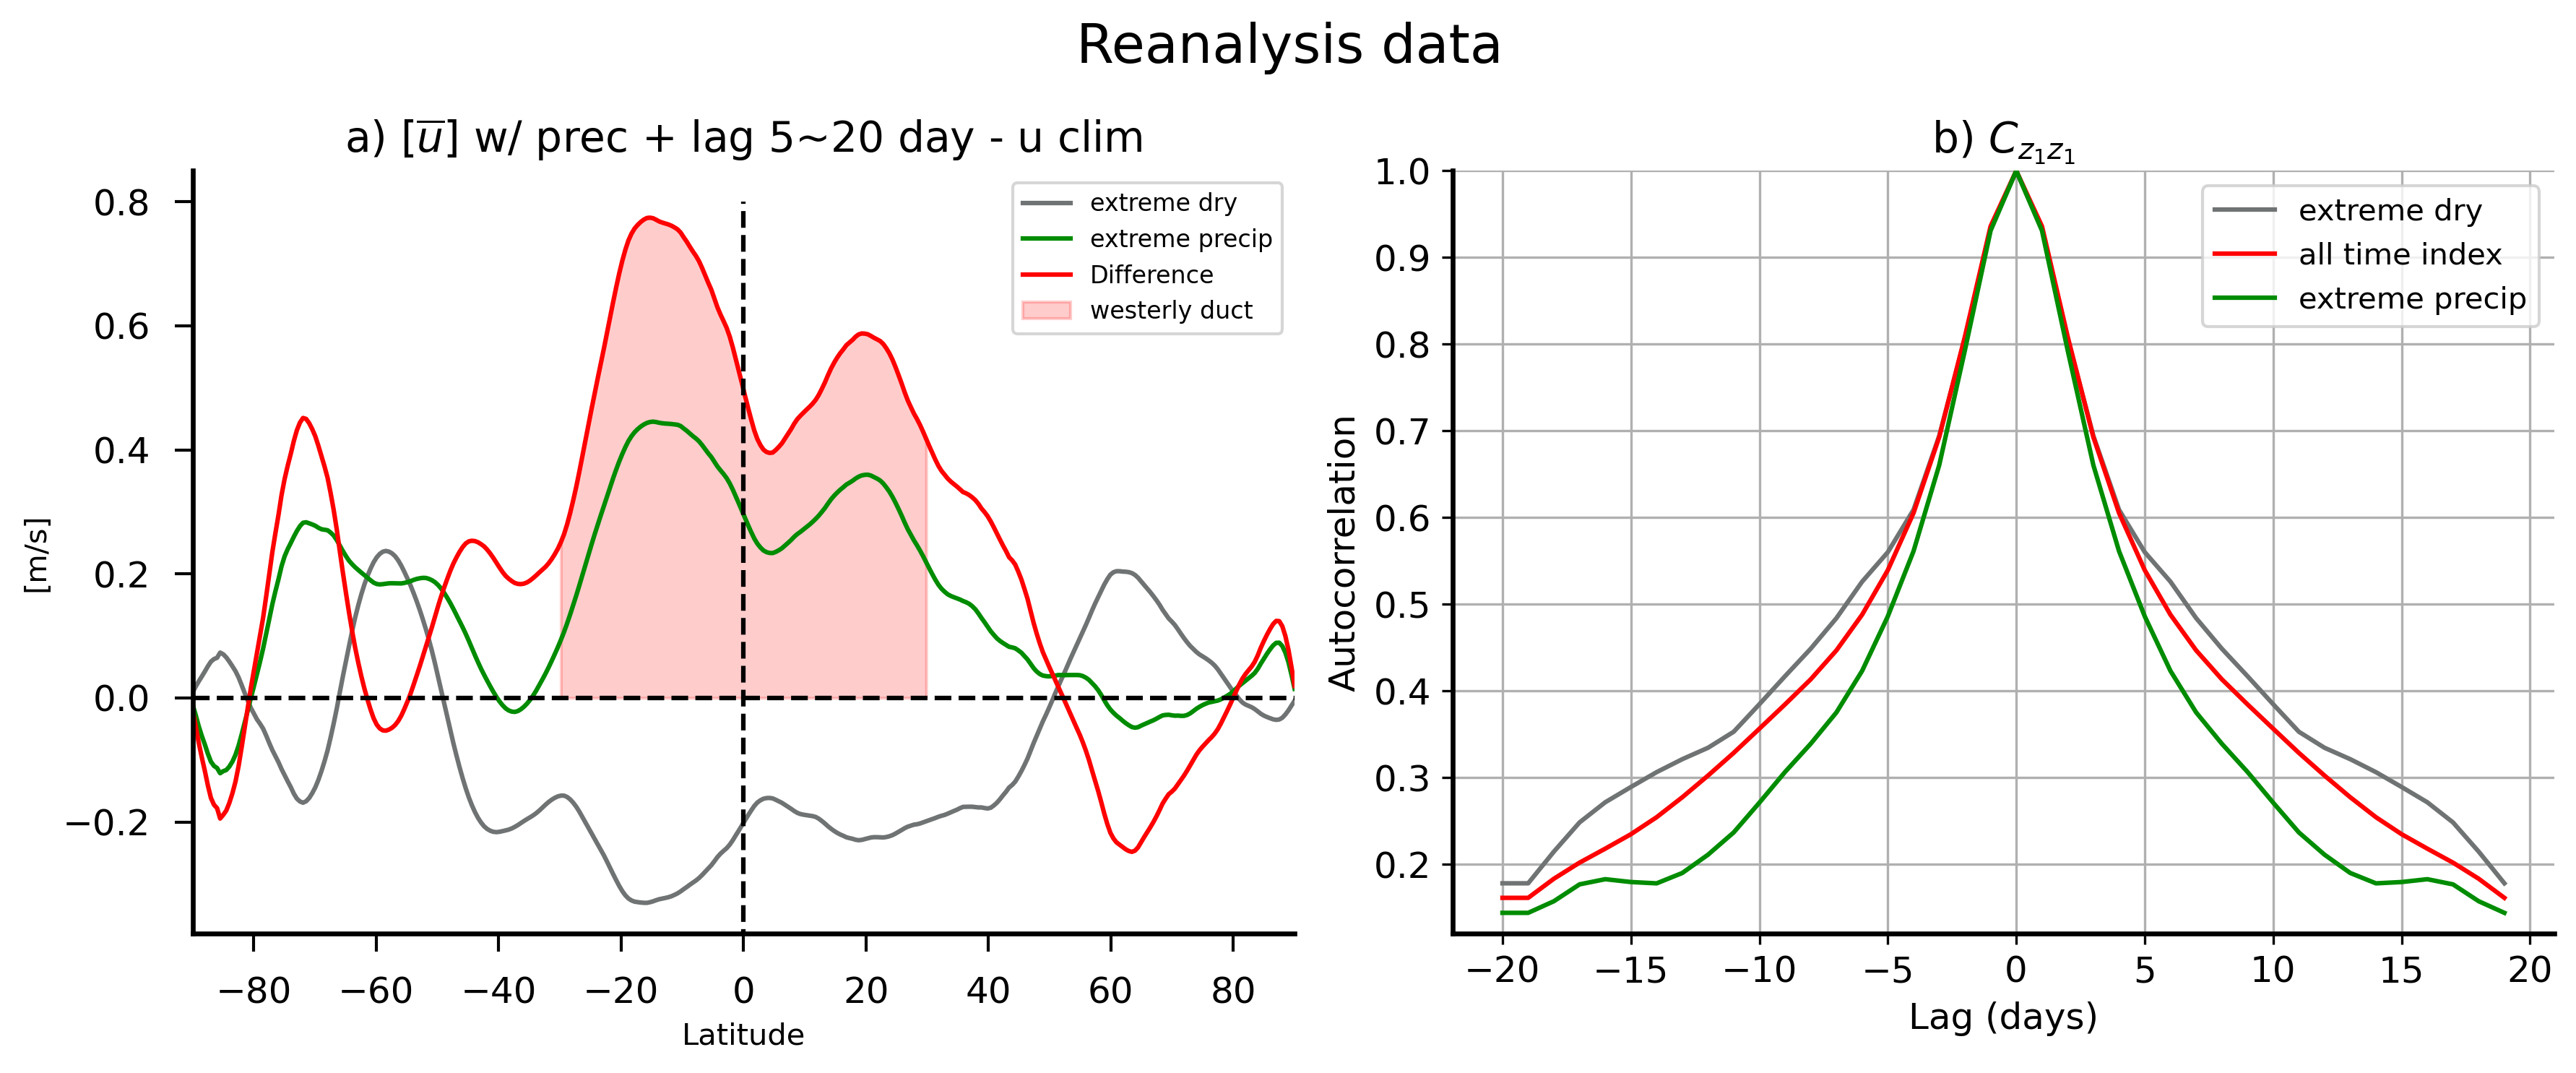

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# 繪圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=300)  # 設定左右佈局
mpl.rcParams['axes.linewidth'] = 1.6

# 左圖：westerly duct plot
ax1.plot(lat_coarse, final_u_dry_avg, label="extreme dry", color=colors[0])
ax1.plot(lat_coarse, final_u_avg, label="extreme precip", color=colors[-1])
ax1.plot(lat_coarse, u_diff_avg, label="Difference", color="Red")

ax1.fill_between(
    lat_coarse, u_diff_avg, 0, 
    where=(lat_coarse >= -30) & (lat_coarse <= 30), 
    color='red', alpha=0.2, label="westerly duct"
)

ax1.set_xlabel("Latitude")
ax1.set_ylabel("[m/s]")
ax1.set_title(r"a) [$\overline{u}$] w/ prec + lag 5~20 day - u clim", fontsize=14)

ax1.legend(fontsize=8)
ax1.hlines(y=0, xmin=-90, xmax=90, lw=1.5, linestyles='--', color="Black")
ax1.vlines(x=0, ymin=-0.4, ymax=0.8, lw=1.5, linestyles='--', color="Black")

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_ylim([-0.38, 0.85])
ax1.set_xlim([-90, 90])
ax1.tick_params(axis="x", labelsize=12, pad=8)
ax1.tick_params(axis="y", labelsize=12, pad=8)
ax1.tick_params(direction="out", length=6, width=1)

# 右圖：autocorrelation plot
lags = np.arange(-20, 20, 1)
ax2.plot(lags, autocorre_dry_symmetric, color=colors[0], label="extreme dry")
ax2.plot(lags, auto_all_symmetric, color="Red", label="all time index")
ax2.plot(lags, autocorre_symmetric, color=colors[-1], label="extreme precip")

ax2.set_title("b) $C_{z_{1}z_{1}}$", fontsize=14)
ax2.set_xlabel("Lag (days)", fontsize=12)
ax2.set_ylabel("Autocorrelation", fontsize=12)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=10)
ax2.grid()
ax2.set_ylim([0.12, 1])

# 全體調整
plt.suptitle("Reanalysis data", fontsize=18)
plt.tight_layout()
plt.savefig(r"/data92/PeterChang/Paper2/Figure/Fig7_Dean's_award.png", dpi=300., bbox_inches='tight')
plt.show()


# Cross correlation

In [2565]:
def cross_corr_chunked(x, y, lag_max, chunk_size, overlap_size):
    """
    Calculate the cross-correlation between two signals x and y, using overlapping chunks.

    Parameters:
    x, y: Input signals to calculate cross-correlation.
    lag_max: Maximum number of lags to compute.
    chunk_size: Size of each chunk (default is 128).
    overlap_size: Number of points to overlap between chunks (default is 64).

    Returns:
    lags: Array of lag values.
    mean_corr: Averaged cross-correlation across all chunks.
    """
    step_size = chunk_size - overlap_size
    num_chunks = (len(x) - overlap_size) // step_size  # Number of chunks with overlap
    print(num_chunks)
    corr_matrix = np.zeros((num_chunks, 2 * lag_max + 1))  # Store cross-correlation for each chunk

    for i in range(num_chunks):
        start = i * step_size
        end = start + chunk_size

        if end > len(x) or end > len(y):  # Avoid going beyond the signal length
            break

        # Extract the chunk from x and y
        x_chunk = x[start:end]
        y_chunk = y[start:end]

        # Compute the cross-correlation for the current chunk        
        corr = np.correlate(x_chunk-np.mean(x_chunk), y_chunk-np.mean(y_chunk), mode='full')
        mid  = len(corr) // 2
        chunk_corr = corr[mid-lag_max:mid+lag_max+1] / (len(x_chunk) * np.std(x_chunk) * np.std(y_chunk))

        # Store the chunk correlation
        corr_matrix[i, :] = chunk_corr

    # Average the cross-correlation across all chunks
    mean_corr = np.mean(corr_matrix, axis=0)
    lags = np.arange(-lag_max, lag_max + 1)

    return lags, mean_corr

In [2740]:
# Set the parameters for chunking and overlap
auto_length = 100
chunk_size =  128 # 128  # Set your chunk size here
overlap_size = 64 # 64  # Set your overlap size here


In [2741]:
# 獲取緯度範圍 (範圍 -20° ~ 20°)
lat_coarse = np.linspace(-90,90,360)
lat_tropic = (lat_coarse >= -10) & (lat_coarse <= 10)  # ✅ 修正布林索引

# 選取該範圍內的降水數據
precip_tropic_for_cross = precip[:, lat_tropic, :] * np.cos(np.deg2rad(lat_coarse[lat_tropic]))[np.newaxis, :,np.newaxis] **0.5   # ✅ 使用布林索引選取

# 計算經度平均 (Zonal Mean, 沿著 axis=1 方向計算)
precip_tropic_zonal_mean_for_cross = np.average(precip_tropic_for_cross, axis=(1,2)) #.mean(axis=(1,2))  # ✅ 計算熱帶區域的經向平均


In [2742]:
PC1_final    = (PC1 - PC1.mean()) / PC1.std()
precip_final = (precip_tropic_zonal_mean_for_cross - precip_tropic_zonal_mean_for_cross.mean())/precip_tropic_zonal_mean_for_cross.std()

In [2743]:
precip_tropic_zonal_mean_for_cross.shape

(7670,)

In [2744]:
lags, cross_corr_values   = cross_corr_chunked(PC1_final, precip_final, auto_length, chunk_size, overlap_size)


118


(-30.0, 30.0)

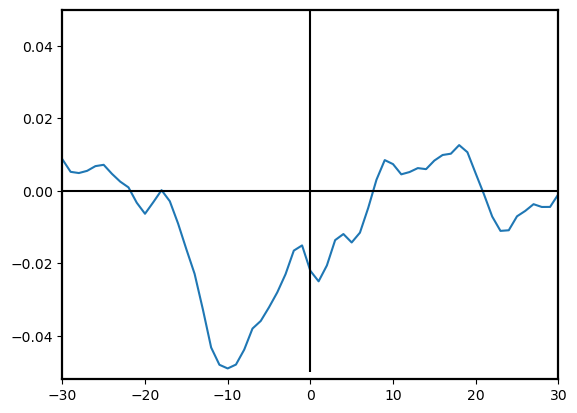

In [2745]:
plt.figure()
plt.plot(lags, cross_corr_values)
plt.hlines(y=0, xmin=-100,xmax=100, lw=1.5, color="Black")
plt.vlines(x=0, ymin=-0.05,ymax=0.05, lw=1.5, color="Black")
plt.ylim([-0.052,0.05])
plt.xlim([-30,30])